# Image Analysis Optional Assignment: Using bag of visual words for scene classification.

## Introduction

### First Part: How do we extract features?

Before extracting features we need to get our hands into a dataset and import the necessary packages. The dataset I used for this project was Caltech 101 with 101 categories, it can be found in the `Caltech101` folder. To download it go to [their website](http://www.vision.caltech.edu/Image_Datasets/Caltech101/Caltech101.html). I also used the **OpenCV Python Package (3.4.1)** in the implementation of this project, to download any version, go to [the official OpenCV website](https://opencv.org/releases.html); other essential packages for Computer Vision, Machine Learning and utilities packages were used such as `numpy`, `os`, `matplotlib` and others.

Image:  C:\Users\diego\Desktop\bag-of-words\data\caltech101\101_ObjectCategories\accordion\image_0003.jpg


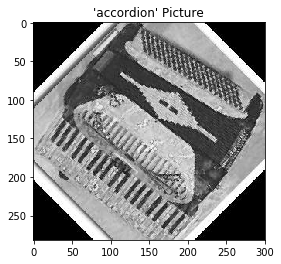

In [286]:
# Import modules
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
import cv2 as cv
import numpy as np
import os
from imutils import paths
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


# Try to read a sample image
imgs_path = '../data/caltech101/101_ObjectCategories'
category_name = 'accordion'
image_name = 'image_0003.jpg'
image_path = (imgs_path, category_name, image_name)
image_path = '/'.join(image_path)
# Convert to absolute otherwise CV will not work
image_path = os.path.abspath(image_path)
print("Image: ", image_path)
# Read image
img  = cv.imread(image_path)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY) # Converts from one color space to another (grayscale)
plt.imshow(gray, cmap='gray')
plt.title("'"+category_name+"'"+' Picture')
plt.show()

Now we can use our sample accordion picture to see how SIFT performs in detecting keypoints.

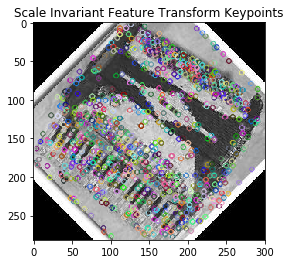

Number of SIFT Keypoints:  997


In [287]:
# Detect SIFT Keypoints
sift        = cv.xfeatures2d.SIFT_create()
# Calculate the N by 128 desciptors
kp, des = sift.detectAndCompute(gray,None)
kpImg = cv.drawKeypoints(gray, kp, img)
plt.imshow(kpImg, cmap='gray')
plt.title("Scale Invariant Feature Transform Keypoints")
plt.show()
print("Number of SIFT Keypoints: ", format(len(kp)))

### Part 2. Getting all the categories based on a given path

For the purpose of brevity, simplicity and computational "cheapness" I am going to use 3 categories, however, the original Caltech database contains 101 categories for image classification. This algorithm can easily be expanded or scaled into any number of categories, although more efficient approaches may be needed for fast computation of the classification task.

In [288]:
train_path = '../data/upf/train_set//'
train_categories = os.listdir(train_path)
print("Training path: ", train_path)
print("Training categories: ", train_categories)

Training path:  ../data/upf/train_set//
Training categories:  ['airplanes', 'camera', 'crab']


In [289]:
# Get all the path to the images and save them in a list
# image_paths and the corresponding label in image_paths
# The path is defined in the `train_path` variable.
# Also, the label is just a number in this case.
image_paths = []
image_classes = []
class_id = 0
for train_category in train_categories:
    dir = os.path.join(train_path, train_category)
    class_path = list(paths.list_images(dir)) # This is the path to all the images given A SINGLE CLASS
    # Stores the path to all the images in the images_paths variable which has all of the training images.
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path) # Assigns a label to each image path
    class_id+=1
print(image_classes)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


### Part 3. Combine Part 1 and Part 2 to detect the Keypoints and Descriptors of all of the images

#### SIFT Note: 

Even though SIFT has different parameters, the paper by Lowe gives some empirical data which can be summarized as, number of octaves = 4, number of scale levels = 5, initial σ=1.6, k=2–√ etc as optimal values.

In [358]:
# Detect SIFT Keypoints
sift        = cv.xfeatures2d.SIFT_create()
# List where all the descriptors will be stored
des_list = []
print("Calculating all the descriptors and keypoints...")
for image_path in image_paths:
    print("Calculating for image ["+ image_path +"]           ", end="\r")
    im  = cv.imread(image_path)
    gray = cv.cvtColor(im,cv.COLOR_BGR2GRAY) # Converts from one color space to another (grayscale)
    kp, des = sift.detectAndCompute(gray,None)
    des_list.append((image_path, kp, des))
print("Done!")

Calculating all the descriptors and keypoints...
Done!lating for image [../data/upf/train_set//crab\image_0073.jpg]                


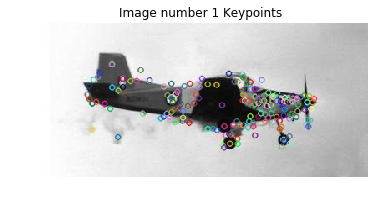

In [359]:
# Example for the 3rd image
N = 1
im = cv.imread(des_list[N][0])
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
kp, des = sift.detectAndCompute(gray, None)
kpImg = cv.drawKeypoints(gray, kp, im)
plt.imshow(im, cmap='gray')
plt.axis("off")
plt.title("Image number "+str(N)+" Keypoints")
plt.show()

In [360]:
# Stack all the descriptors vertically in a numpy array
print("Stacking all the descriptors in a numpy array...")
descriptors = des_list[0][2]
for image_path, keypoints, descriptor in des_list[1:]:
    print("Calculating for image ["+ image_path +"]           ", end="\r")
    descriptors = np.vstack((descriptors, descriptor))
print("\nDone!")

Stacking all the descriptors in a numpy array...
Calculating for image [../data/upf/train_set//crab\image_0073.jpg]                
Done!


#### Optional. Save the descriptors variable in an external file.

In [361]:
pickle.dump(descriptors, open('descriptors.sav', 'wb'))

### Part 4. Apply K-means

In [362]:
# Perform k-means clustering
k = 100
voc, variance = kmeans(descriptors, k, 1)
print("Done doing K-means")

Done doing K-means


In [363]:
# Create the histogram itself of the image features
im_features = np.zeros((len(image_paths), k), "float32")
for i in range(len(image_paths)):
    print("Calculating distance for image "+str(i)+"...", end="\r")
    words, distance = vq(des_list[i][2],voc)
    for w in words:
        im_features[i][w] += 1

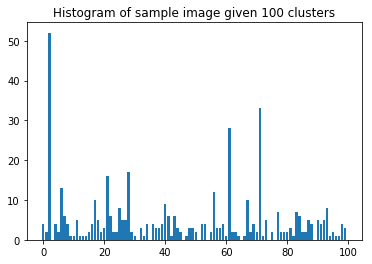

In [381]:
plt.bar(range(k), im_features[2])
plt.title("Histogram of sample image given "+ str(k) + " clusters")
plt.show()

In [377]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')

# Scaling the words
stdSlr = StandardScaler().fit(im_features)
scaled_im_features = stdSlr.transform(im_features)

### Part 5. Train a Support Vector Machine Classifier

In [378]:
# Train the Linear SVM
clf = LinearSVC()
clf.fit(scaled_im_features, np.array(image_classes))

# Save the SVM
joblib.dump((clf, train_categories, stdSlr, k, voc), "svm.pkl", compress=3)

['svm.pkl']